# Loading the data

In [1]:
from keras.datasets import boston_housing
(training_data, training_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
# take a look at the data
print(training_data.shape)
print(training_targets.shape)

print(test_data.shape)

(404, 13)
(404,)
(102, 13)


# Preprocessing the data

In [3]:
mean = training_data.mean(axis=0)
print(mean)

[  3.74511057e+00   1.14801980e+01   1.11044307e+01   6.18811881e-02
   5.57355941e-01   6.26708168e+00   6.90106436e+01   3.74027079e+00
   9.44059406e+00   4.05898515e+02   1.84759901e+01   3.54783168e+02
   1.27408168e+01]


In [4]:
training_data -= mean

std = training_data.std(axis=0)
print(std)

[  9.22929073e+00   2.37382770e+01   6.80287253e+00   2.40939633e-01
   1.17147847e-01   7.08908627e-01   2.79060634e+01   2.02770050e+00
   8.68758849e+00   1.66168506e+02   2.19765689e+00   9.39946015e+01
   7.24556085e+00]


In [5]:
training_data /= std

In [6]:
# processing the test data with same mean and std
test_data -= mean
test_data /= std

# Building the network

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(training_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold validation

In [9]:
import numpy as np

k = 4
num_val_samples = len(training_data) // k
num_epoches = 100
all_scores = []

for i in range(k):
    print("processing fold #", i)
    val_data = training_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = training_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [training_data[:i * num_val_samples],
        training_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [training_targets[:i * num_val_samples],
        training_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epoches, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


# Saving hte validation logs at each fold

In [16]:
num_epoches = 500
all_mae_histories = []

for i in range(k):
    print("processing fold #", i)
    val_data = training_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = training_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [training_data[:i * num_val_samples],
        training_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [training_targets[:i * num_val_samples],
        training_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epoches, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


# plotting validation scores

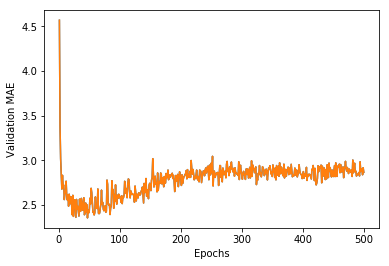

In [20]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epoches)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()